In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

In [173]:
long_short_returns = pd.read_pickle("long_short_returns.pkl")

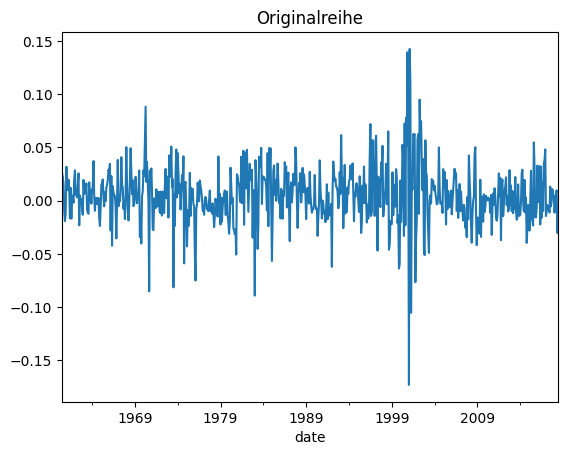

ADF p-Wert: 0.0


/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


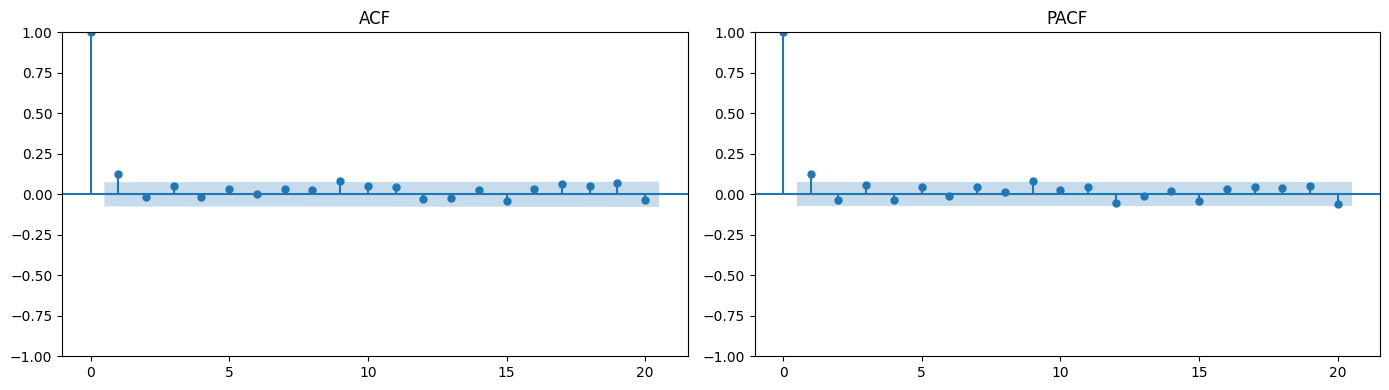

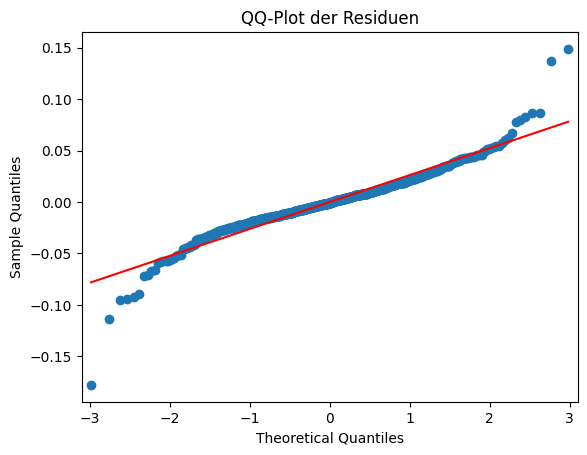

     lb_stat  lb_pvalue
10  2.028177    0.99612


In [175]:
#Box Jenkins Analysis
#!pip install statsmodels


long_short_returns.plot(title="Originalreihe")
plt.show()

# ADF-Test
from statsmodels.tsa.stattools import adfuller
result = adfuller(long_short_returns.dropna())
print(f"ADF p-Wert: {result[1]}")

#Model fit
#ar_order = [0,1,2,3,4,5, 6, 7]
#i_order = [0,1,2,3,4,5]
#ma_order = [0,1,2,3,4,5]
#fit = []
#for p in ar_order:
#    for d in i_order:
#        for q in ma_order:
#            model = ARIMA(df_ls["long_short_ret"], order=(p, d, q))  # (p,d,q): AR, differenzieren, MA
#            model_fit = model.fit()
#            fit.append({"likelihood" : model_fit.llf, "P": p, "D" : d, "Q" : q})
#best_model = max(fit, key=lambda x: x["likelihood"])

#print("Bestes Modell:")
#print(best_model)

model = ARIMA(long_short_returns, order=(5,0,5))
model_fit = model.fit()
model_fit.summary()           

#ACF, PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(long_short_returns, lags=20, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(long_short_returns, lags=20, ax=axes[1], method="ywm")  # "ywm" ist stabil bei kurzen Reihen
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

residuen = model_fit.resid

qqplot(residuen, line='s')  # 's' = standardized line
plt.title("QQ-Plot der Residuen")
plt.show()

# Jarque-Bera-Test durchführen
jb_test = jarque_bera(residuen)
jb_test

lb_test = acorr_ljungbox(residuen, lags=[10], return_df=True)
print(lb_test)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 505714286.1107774
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1640.4340355529794
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1640.434036411902
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2


/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007086. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


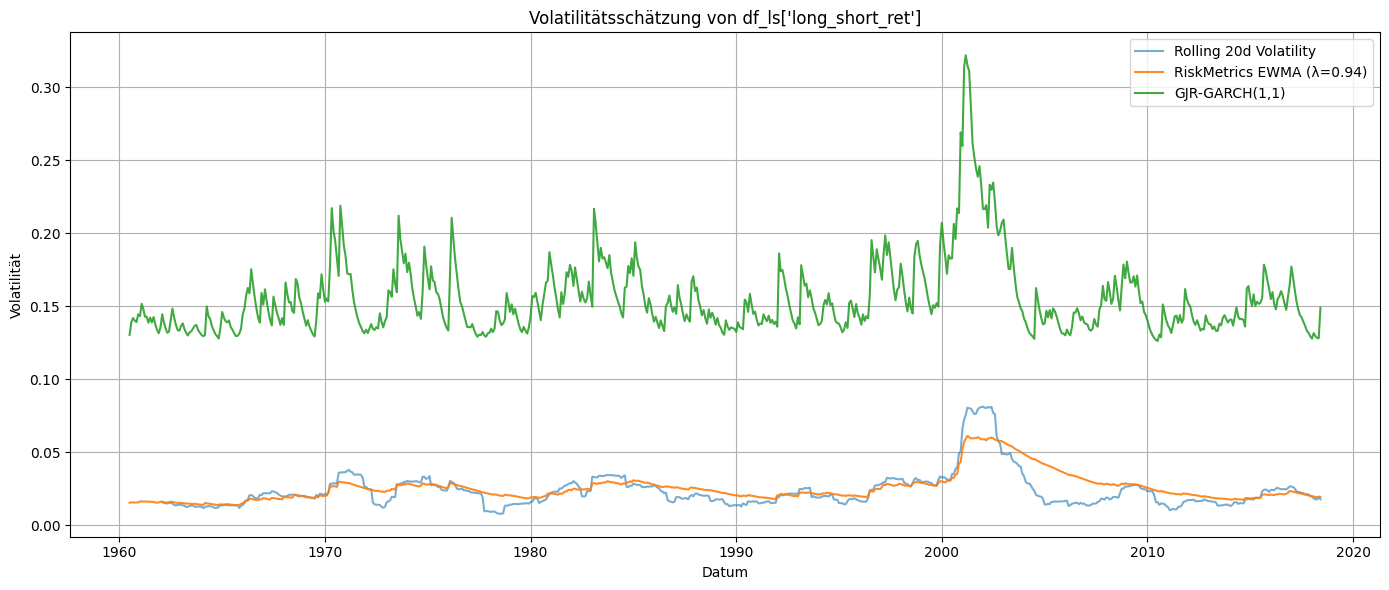

In [177]:

# 1️⃣ Lade deine Renditen
returns = long_short_returns.dropna()

# 2️⃣ Berechne echte (empirische, rolling) Volatilität (z. B. 20 Tage)
rolling_vol = returns.rolling(window=20).std()

# 3️⃣ RiskMetrics EWMA Volatilität (λ = 0.97 -> monatliche Daten)
lambda_ = 0.97
sigma2_rm = [returns[:30].var()]  # Startwert: Varianz der ersten 30 Werte
for r in returns[1:]:
    sigma2_rm.append((1 - lambda_) * r**2 + lambda_ * sigma2_rm[-1])
ewma_vol = np.sqrt(sigma2_rm)
ewma_vol = pd.Series(ewma_vol, index=returns.index)

# 4️⃣ GJR-GARCH(1,1) Volatilität schätzen
gjr_model = arch_model(returns, vol='GARCH', p=1, q=1, o=1)
gjr_fit = gjr_model.fit()
gjr_vol = np.sqrt(gjr_fit.conditional_volatility)

# Index aller Volatilitäts-Zeitreihen in datetime konvertieren
rolling_vol.index = rolling_vol.index.to_timestamp()
ewma_vol.index = ewma_vol.index.to_timestamp()
gjr_vol.index = gjr_vol.index.to_timestamp()

# 5️⃣ Plot: Vergleich der Volatilitätsschätzungen
plt.figure(figsize=(14, 6))
plt.plot(rolling_vol, label="Rolling 20d Volatility", alpha=0.6)
plt.plot(ewma_vol, label="RiskMetrics EWMA (λ=0.94)", alpha=0.9)
plt.plot(gjr_vol, label="GJR-GARCH(1,1)", alpha=0.9)
plt.title("Volatilitätsschätzung von df_ls['long_short_ret']")
plt.xlabel("Datum")
plt.ylabel("Volatilität")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Iteration:      1,   Func. Count:      5,   Neg. LLF: -1646.9311577323665
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1646.9311581365625
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:                1646.93
Distribution:                  Normal   AIC:                          -3285.86
Method:            Maximum Likelihood   BIC:                          -3267.68
                                        No. Observations:                  696
Date:                Tue, May 20 2025   Df Residuals:                      696
Time:                        00:00:50   Df Model:                            0
       

/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006852. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


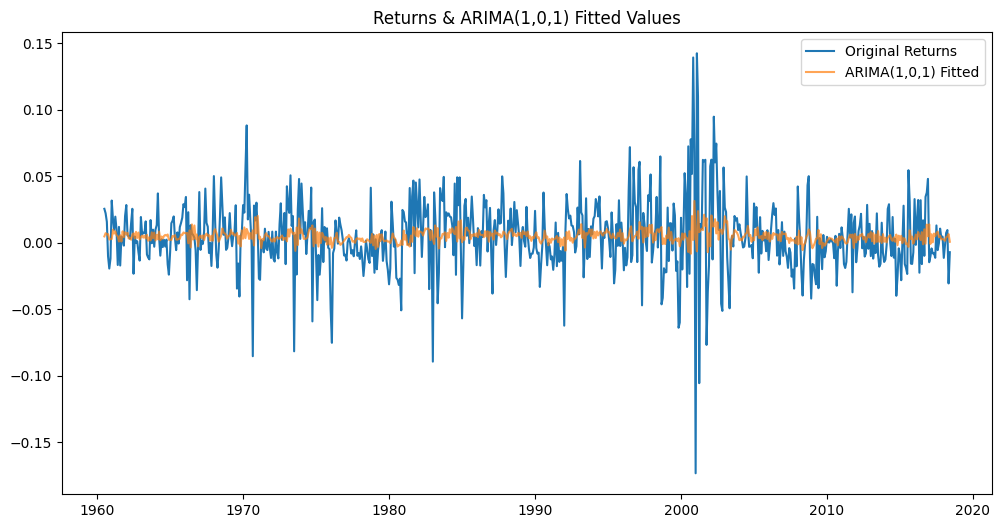

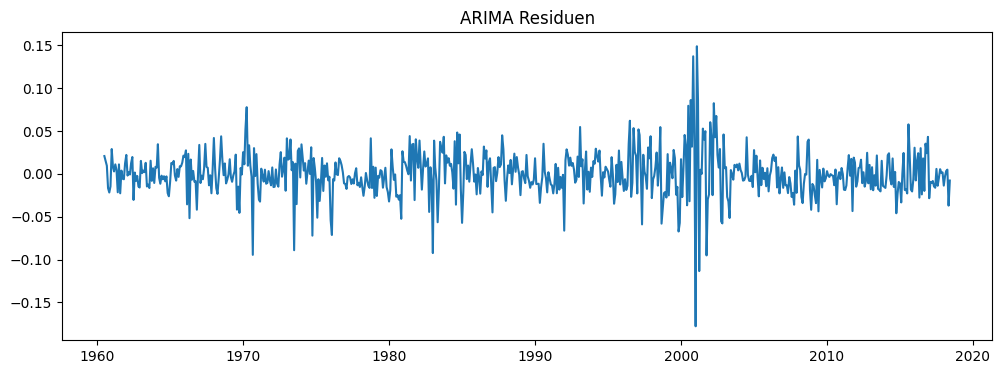

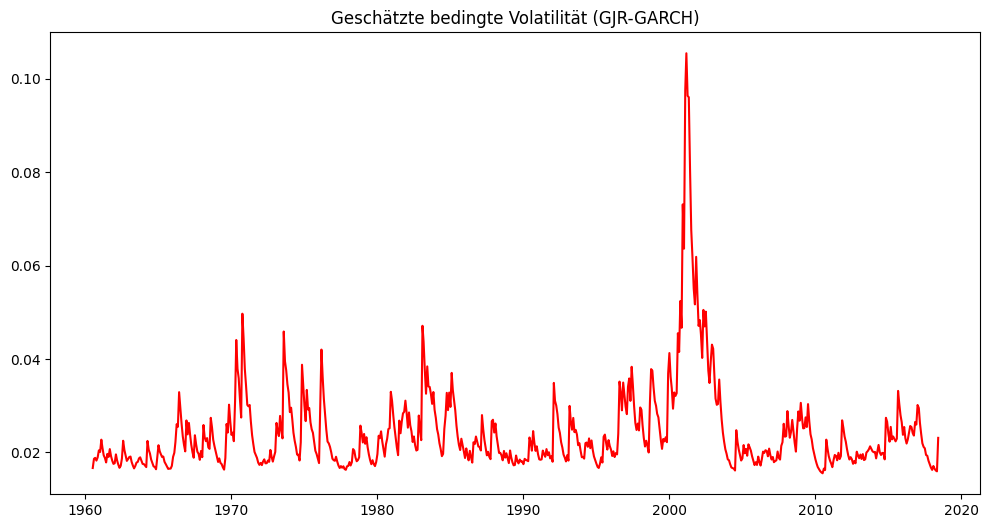

In [178]:
returns = long_short_returns.dropna()
returns.index = returns.index.to_timestamp()

# ARIMA(1,0,1) fit
arima_model = ARIMA(returns, order=(5,0,5))
arima_res = arima_model.fit()

arima_resid = arima_res.resid


# GJR-GARCH(1,1)
garch_model = arch_model(arima_resid, vol='GARCH', p=1, o=1, q=1, dist='normal', mean='Zero')

# Fit mit robusten (Bollerslev-Wooldridge) Standardfehlern
garch_res = garch_model.fit(cov_type='robust')

print(garch_res.summary())

# 1. Original Returns + ARIMA gefittete Werte
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns, label='Original Returns')
plt.plot(returns.index, arima_res.fittedvalues, label='ARIMA(1,0,1) Fitted', alpha=0.7)
plt.title('Returns & ARIMA(1,0,1) Fitted Values')
plt.legend()
plt.show()

# 2. ARIMA Residuen
plt.figure(figsize=(12, 4))
plt.plot(arima_resid.index, arima_resid)
plt.title('ARIMA Residuen')
plt.show()

# 3. GJR-GARCH geschätzte bedingte Volatilität (Conditional Volatility)
plt.figure(figsize=(12, 6))
plt.plot(garch_res.conditional_volatility, color='red')
plt.title('Geschätzte bedingte Volatilität (GJR-GARCH)')
plt.show()

/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_53593/1280346441.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date, periods=horizon+1, freq='M')[1:]  # +1, weil Startdatum weg


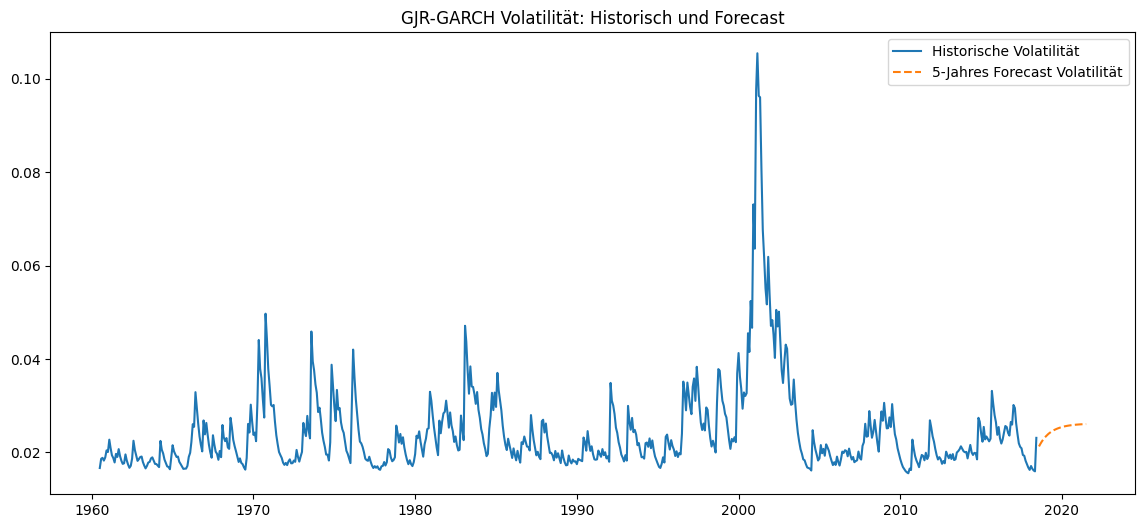

In [179]:
horizon = 3 * 12  # 5 Jahre * 12 Monate

garch_vol = garch_res.conditional_volatility.copy()

garch_forecast = garch_res.forecast(horizon=horizon, reindex=False)

# Forecast Varianz für nächsten 5 Jahre
forecast_var = garch_forecast.variance.iloc[-1]

# Volatilität = sqrt(Varianz)
forecast_vol = np.sqrt(forecast_var)

# Erstelle passende Zeitachse für die Forecast-Zeiträume
last_date = garch_vol.index[-1]

# Beispiel: für monatliche Daten
forecast_index = pd.date_range(start=last_date, periods=horizon+1, freq='M')[1:]  # +1, weil Startdatum weg

forecast_vol.index = forecast_index


plt.figure(figsize=(14,6))
plt.plot(garch_vol.index, garch_vol, label='Historische Volatilität')
plt.plot(forecast_vol.index, forecast_vol, label='5-Jahres Forecast Volatilität', linestyle='--')
plt.title('GJR-GARCH Volatilität: Historisch und Forecast')
plt.legend()
plt.show()
